# Orientation vector comparison
Notebook for:
1. creatinon of "fake" orientation vector, starting in (0,0) then moving withevent velocity 
2. comparison to flatten orientatinon vector

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set(color_codes=True)

# loading data
df = {}
event = {}

fname = [
    'VRAcuityExp_2017-07-13_14-39-17_VR-4A_NIC',
    'VRAcuityExp_2017-07-13_15-05-16_VR-2B_NIC',
    'VRAcuityExp_2017-07-13_15-19-09_VR-2A_EDU',
    'VRAcuityExp_2017-07-13_15-38-34_VR-1A_NIC',
    'VRAcuityExp_2017-07-13_15-53-40_VR-1B_NIC',
    'VRAcuityExp_2017-07-13_16-11-46_VR-3A_NIC',
    'VRAcuityExp_2017-07-13_16-27-08_VR-3A_NIC',
    'VRAcuityExp_2017-07-13_17-09-07_VR-5A_NIC', ]
                                                                            
path = '../datasets/preprocessed/'

for i, x in enumerate(fname):
    df[i]    = pd.read_hdf(path+x+'_filter.h5'           , 'Full' )
    event[i] = pd.read_hdf(path+'analysis/'+x+'_event.h5', 'Event')      
                                                                                                                                    

In [2]:
# in use functions
def angle_zero(df):
    V1 = np.array([df.lx1, 0, df.lz1])
    V2 = np.array([1     , 0, 0     ])
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    df['theta0'] = np.arccos(CosTheta)
    return df

def angle_cos(V1, V2):
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    return CosTheta

def decompose_vec_df(df):
    # get two vectors aligned with Y and Z axes
    Vo = np.array([df.X_Ori, df.Y_Ori, df.Z_Ori])  
    Vz = np.array([df.X_Ori, df.Y_Ori, 0       ])  
    Vx = np.array([0       , df.Y_Ori, df.Z_Ori])

    # find the angles between them and orientation vector 
    df['lx1'] = angle_cos(Vo, Vz)
    df['lz1'] = angle_cos(Vo, Vx)
    return df


In [3]:
i = 3
# merge event df with collected data df
dfV = pd.merge(event[i], df[i], on='Frame')

#clearing data off useless variables
dfV.rename(columns={"Time_Ori":'Time'}, inplace=True)
dfV.drop({'Time_Pos', 'X_Pos', 'Y_Pos', 'Z_Pos', 'dX', 'dY', 'dZ',}, axis=1, inplace=True)


## Flattening the orientation vector
To represent the change on XZ - 2D orientation

In [4]:
# calculating lenghts of VecX and VecZ and creation of shifted vectors
dfV = dfV.apply(decompose_vec_df, axis=1)
dfV['V1'] = np.linalg.norm(np.array([dfV.lx1, 0, dfV.lz1]))

# propagate the sign of a X, Z to new vector
dfV['lx1'] = dfV.apply(lambda row: row.lx1 * (row.X_Ori / np.absolute(row.X_Ori)), axis=1)
dfV['lz1'] = dfV.apply(lambda row: row.lz1 * (row.Z_Ori / np.absolute(row.Z_Ori)), axis=1)

# normalize the data to unit vector form
dfV['lx1'] = dfV.apply(lambda row: row.lx1 / row.V1, axis=1)
dfV['lz1'] = dfV.apply(lambda row: row.lz1 / row.V1, axis=1)

dfV.dropna(inplace=True)

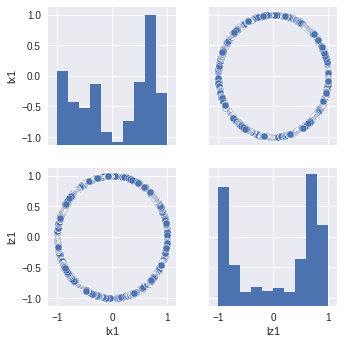

In [5]:
# plot - flattened orientation fo one experiment s
fig = plt.figure(figsize=(12,12))
sns.pairplot(dfV, vars=['lx1', 'lz1'])

## Creation of event fake orietation vector
New fake orientation vector created. Starting from (1,0) or from original orientation of the animal, vector just in XZ - 2D plane. Looking for similarities in between fake orientation vector and rat's orientation.

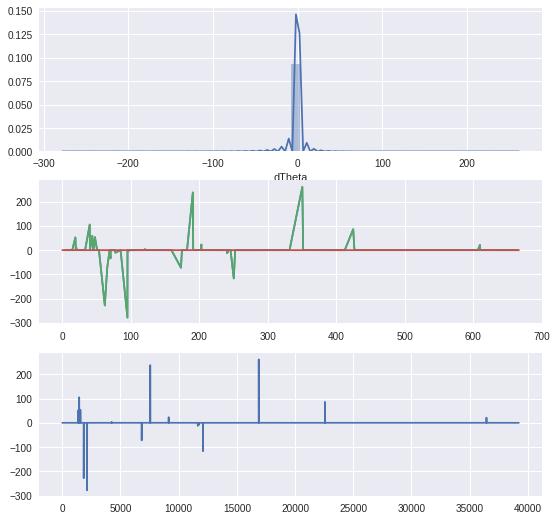

In [6]:

# calculating change of angle based on change of time and speed of the event
dfV['dTheta'] = dfV.apply(lambda row: row.dTime * row.speed, axis=1)
dftemp = dfV.drop({'MotiveExpTimeSecs', 'lx1', 'lz1', ' Time', 'visible', 'Vxyz', 'V1', 'X_Ori', 'Y_Ori', 'Z_Ori'}, axis=1)

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

r = range(0, len(dftemp.Time))

sns.distplot(dftemp.dTheta, ax=ax1)
c2 = ax2.plot(dftemp.Time , dftemp.dTheta, event[i].Time, event[i].speed/200)
c2 = ax3.plot(r, dftemp.dTheta)


## Comparison of fake vectors vs orientation vector of the animal in XZ 
Method - Comparing the angles change:
dThetaFake - theta 


In [7]:
dfV = dfV.apply(angle_zero, axis=1) # calculation with use of origin

dfV['theta1'] = dfV.theta0.shift(1)
dfV['theta']  = dfV.apply(lambda row: row.theta0 - row.theta1, axis=1)

dfV.drop({'theta0','theta1'}, axis=1, inplace=True)


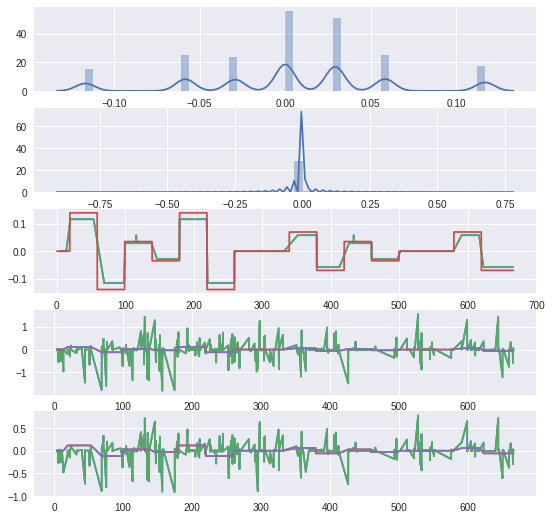

In [8]:
# Filtering thetas 
dfV  = dfV[dfV['dTime'] < 0.1]

limdTheta = 0.2
limtheta  = 2
dfV = dfV[dfV['dTheta'] < limdTheta]
dfV = dfV[dfV['dTheta'] >-limdTheta]
dfV = dfV[dfV['theta'] < limtheta]
dfV = dfV[dfV['theta'] >-limtheta]

dfV['M'] = dfV['theta'].rolling(window=2).mean()
dfV.dropna(inplace=True)

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)

r = range(0, len(dftemp.Time))

sns.distplot(dfV.dTheta, ax=ax1)
sns.distplot(dfV.M , ax=ax2)
c2 = ax3.plot(dfV.Time, dfV.dTheta, event[i].Time, event[i].speed/200)
c2 = ax4.plot(dfV.Time, dfV.theta, dfV.Time, dfV.dTheta)
c3 = ax5.plot(dfV.Time, dfV.M, dfV.Time, dfV.dTheta)


In [9]:
# substracting the theta values
dfV['subTheta']  = dfV.apply(lambda row: row.dTheta - row.theta, axis=1)
dfV['subThetaM'] = dfV.apply(lambda row: row.dTheta - row.M, axis=1)


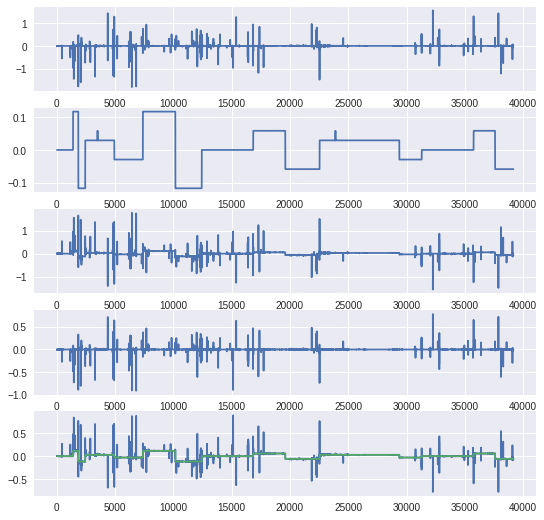

In [10]:
# plot in range not in time, to remove filtered time elements 
r = range(0, len(dfV.Time))
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)

c2 = ax1.plot(r, dfV.theta)
c2 = ax2.plot(r, dfV.dTheta)
c2 = ax3.plot(r, dfV.subTheta)
c2 = ax4.plot(r, dfV.M)
c2 = ax5.plot(r, dfV.subThetaM,r,  dfV.dTheta)


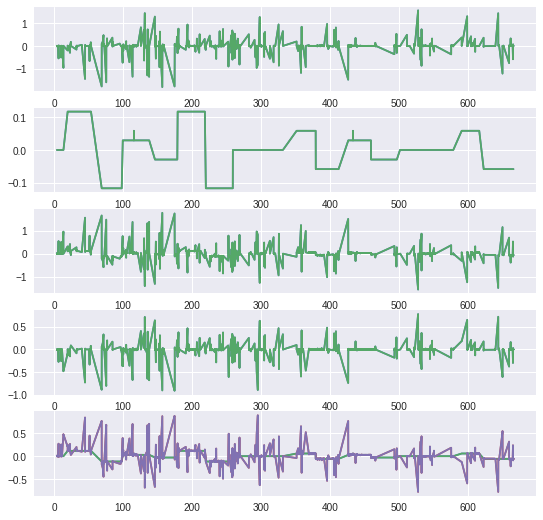

In [11]:
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)

c2 = ax1.plot(dfV.Time, dfV.theta)
c2 = ax2.plot(dfV.Time, dfV.dTheta)
c2 = ax3.plot(dfV.Time, dfV.subTheta)
c2 = ax4.plot(dfV.Time, dfV.M)
c2 = ax5.plot(dfV.Time, dfV.dTheta, dfV.Time, dfV.subThetaM)


## Stimulus-related behavior
Looking for frames detected as SRB. According to:
SRB = {f E FRAMES: ||Vhead - Vstim|| < Dmax

In [12]:
# creation of needed dataset
print(dfV.keys())
dfSRB = dfV.copy()
dfSRB.drop({'MotiveExpTimeSecs', 'X_Ori', 'Y_Ori', 'Z_Ori', 'dTime', 'Vxyz', 'lx1', 'lz1', 'V1',
                'thetaOrig', 'theta', 'UOrig', 'M', 'corr','corrM', 'subU', }, axis=1, inplace=True)

dfSRB.dropna(inplace=True)


Index(['Frame', 'Time', 'MotiveExpTimeSecs', 'visible', 'speed', 'Time',
       'X_Ori', 'Y_Ori', 'Z_Ori', 'dTime', 'Vxyz', 'lx1', 'lz1', 'V1',
       'dTheta', 'theta', 'M', 'subTheta', 'subThetaM'],
      dtype='object')


In [13]:
 # setting Dmax as 20% of velocity at given moment // what about 0
dfSRB['Dmax'] = dfSRB.apply(lambda row: row.dTheta * 0.2, axis=1)
dfSRB['SRB']  = dfSRB.apply(lambda row: np.absolute(row.subTheta) < np.absolute(row.Dmax), axis=1)

# checking lenght of SRB frames in the filtered experiment data
sumSRB = len(dfSRB[dfSRB['SRB']])

#  temp dataframes with stimuli being present or not
dfSRBVis = dfSRB[dfSRB['visible']]
dfSRBInvis = dfSRB[~dfSRB['visible']]

sumSRBVis   = len(dfSRBVis[dfSRBVis['SRB']])
sumSRBInvis = len(dfSRBInvis[dfSRBInvis['SRB']])
 
print(fname[i])
print('stimulus-related behavior: %f%%'     % (sumSRB      * 100 / len(dfSRB)     ))
print('SRM when stimuli is visible: %f%%'   % (sumSRBVis   * 100 / len(dfSRBVis)  ))
print('SRM when stimuli is invisible: %f%%' % (sumSRBInvis * 100 / len(dfSRBInvis)))

pd.set_option('display.max_rows', 2000)
#print(dfSRB[dfSRB['SRB']])

VRAcuityExp_2017-07-13_15-38-34_VR-1A_NIC
stimulus-related behavior: 0.071469%
SRM when stimuli is visible: 0.103116%
SRM when stimuli is invisible: 0.007696%
